In [92]:
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import time

from torch import nn, optim
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets
from torchvision.transforms import v2
from torchinfo import summary
from tqdm.auto import tqdm

In [131]:
DATA_DIR='../datasets/cable_dataset_tester/images/dae_dataset/'
MODEL_OUT='../models'
GRAPH_OUT='results'
NET_NAME='cable_novelty.pt'
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
IMG_SHAPE = (300, 600, 1)
LATENT_DIM = 2
BATCH_SIZE = 256

In [132]:
class DAE(nn.Module):
    def __init__(self, img_shape: tuple, latent_dim: int) -> None:
        super(DAE, self).__init__()
        self.img_shape = img_shape
        
        self.linear1 = nn.Linear(np.prod(img_shape), 128)
        self.linear2 = nn.Linear(128, 256)
        self.linear3 = nn.Linear(256, 512)
        self.latent1 = nn.Linear(512, latent_dim)
        
        self.latent2 = nn.Linear(latent_dim, 512)
        self.linear4 = nn.Linear(512, 256)
        self.linear5 = nn.Linear(256, 128)
        self.linear6 = nn.Linear(128, np.prod(img_shape))
        
        self.relu = nn.LeakyReLU(negative_slope=.1, inplace=True)
        self.tanh = nn.Tanh()
    
    def encode(self, x):
        h1 = self.relu(self.linear1(x))
        h2 = self.relu(self.linear2(h1))
        return self.relu(self.linear3(h2))
    
    def decoder(self, z):
        h4 = self.relu(self.linear4(z))
        h5 = self.relu(self.linear5(h4))
        return self.tanh(self.linear6(h5))
        
    def forward(self, img):
        og_shape = img.shape
        img_flat = img.view(img.shape[0], -1)
        z = self.encode(img_flat)
        recon = self.decoder(z)
        return recon.view(og_shape)

In [133]:
model: nn.Module = DAE(IMG_SHAPE, LATENT_DIM).to(DEVICE)
model.load_state_dict(torch.load(os.path.join(MODEL_OUT, NET_NAME), 
                                 weights_only=True))
model.eval()

DAE(
  (linear1): Linear(in_features=180000, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=256, bias=True)
  (linear3): Linear(in_features=256, out_features=512, bias=True)
  (latent1): Linear(in_features=512, out_features=2, bias=True)
  (latent2): Linear(in_features=2, out_features=512, bias=True)
  (linear4): Linear(in_features=512, out_features=256, bias=True)
  (linear5): Linear(in_features=256, out_features=128, bias=True)
  (linear6): Linear(in_features=128, out_features=180000, bias=True)
  (relu): LeakyReLU(negative_slope=0.1, inplace=True)
  (tanh): Tanh()
)

In [134]:
img_transforms = v2.Compose([
    v2.Resize(IMG_SHAPE[:-1]),
    v2.Grayscale(),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
])

val_set = datasets.ImageFolder(
    os.path.join(DATA_DIR, 'test'),
    transform=img_transforms)

val_loader = DataLoader(val_set, BATCH_SIZE, shuffle=False)

0.25400567054748535


<Figure size 1600x1200 with 0 Axes>

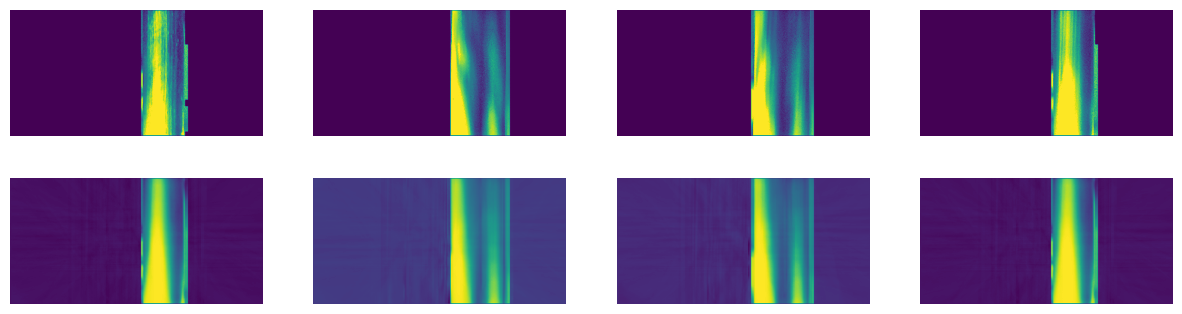

In [135]:
import matplotlib.pyplot as plt

start = time.time()

with torch.no_grad():
    for data, _ in val_loader:
        data = data.to(DEVICE)
        recon = model(data)
        break
    
print(time.time() - start)

plt.figure(dpi=250)

fig, ax = plt.subplots(2, 4, figsize=(15, 4))

for i in range(4):
    ax[0, i].imshow(data[i].cpu().numpy().transpose((1, 2, 0)))
    ax[1, i].imshow(recon[i].cpu().numpy().transpose((1, 2, 0)))
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')
    
plt.show()

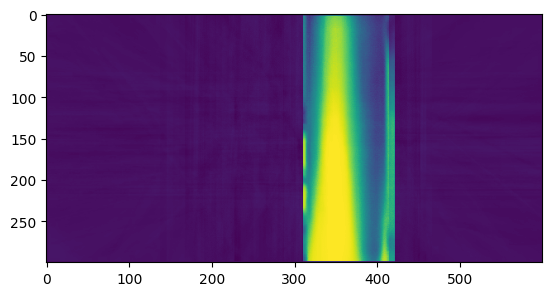

In [136]:
plt.imshow(recon[0].cpu().numpy().transpose(1,2,0))

In [137]:
def pearson_correlation(p1, p2):
    """Pearson correlation method

    Args:
        p1 (np.array): original image
        p2 (np.array): generated image

    Returns:
        float: pearson correlation between images
    """
    return np.corrcoef(p1.flatten(), p2.flatten(), rowvar=False)[0][1]

corr = list(map(pearson_correlation, data.cpu().numpy(), recon.cpu().numpy()))

print(f'Pearson Correlation Coefficients:\n\
    Min: {np.min(corr)}\n\
    Median: {np.median(corr)}\n\
    Max: {np.max(corr)}')

Pearson Correlation Coefficients:
    Min: 0.9549658149416568
    Median: 0.9799630583296337
    Max: 0.9901081087982254


In [138]:
def stats(arr):
    """Calculates the IQR of array elements.

    Args:
        arr (np.array): array with numeric values

    Returns:
        float: IQR calculated from quartiles
        float: lower bound for anomaly detection
        float: higher bound for anomaly detection
    """
    q75, q25 = np.percentile(arr, [75, 25])
    iqr = q75 - q25
    return iqr, q25 - 1.5 * iqr, q75 + 1.5 * iqr

iqr, lower_bound, higher_bound = stats(list(map(pearson_correlation, 
                                                data.cpu().numpy(), 
                                                recon.cpu().numpy())))

print(f'IQR: {iqr}\nLower Bound: {lower_bound}\nHigher Bound: {higher_bound}')

IQR: 0.008048358509502695
Lower Bound: 0.963608371833327
Higher Bound: 0.9958018058713378


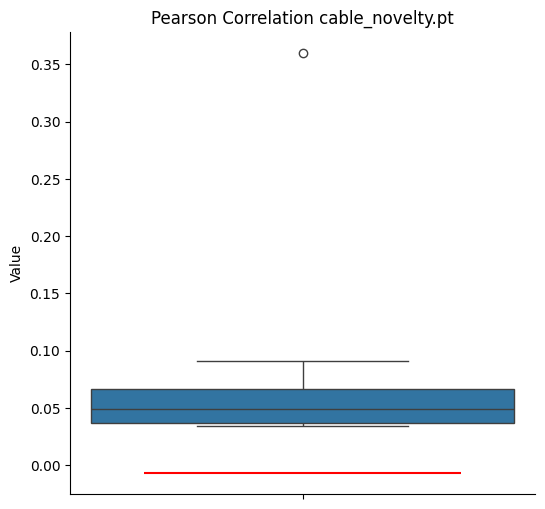

In [128]:
fig, ax = plt.subplots(figsize=(6,6))
bxp = sns.boxplot(corr)
bxp.set(ylabel='Value', title=f'Pearson Correlation {NET_NAME}')
ax.hlines(lower_bound, -.3, .3, colors='red')
# plt.ylim(.99, 1.01)
sns.despine()

/tmp/ipykernel_233863/588617013.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(distribution)


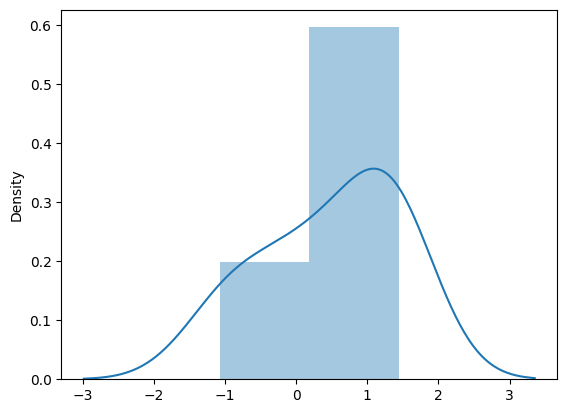

In [129]:
distribution = np.random.normal(corr)

sns.distplot(distribution)
plt.show()

In [130]:
threshold = 0.963608371833327

for c in corr:
    if c < threshold:
        print("Cabo quebrado!")
    

Cabo quebrado!
Cabo quebrado!
Cabo quebrado!
Cabo quebrado!
Cabo quebrado!
Cabo quebrado!
Cabo quebrado!
Cabo quebrado!


<Figure size 1600x1200 with 0 Axes>

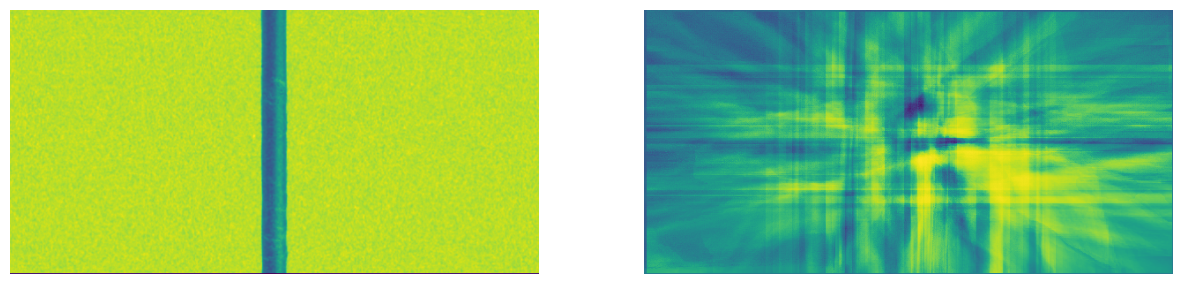

In [108]:
for i, c in enumerate(corr):
    if c < threshold:
        plt.figure(dpi=250)

        fig, ax = plt.subplots(1, 2, figsize=(15, 4))

        for img in range(2):
            ax[0].imshow(data[img].cpu().numpy().transpose((1, 2, 0)))
            ax[1].imshow(recon[img].cpu().numpy().transpose((1, 2, 0)))
            ax[0].axis('OFF')
            ax[1].axis('OFF')
        break